In this notebook, we evaluate the gender and emotion word bias for AWS and Google sentiment APIs using  of the emotion words using the corpus defined in https://saifmohammad.com/WebPages/Biases-SA.html.
We use a paired Wilcoxon signed-rank test.

In [2]:
import pandas as pds
import numpy as np
from scipy.stats import wilcoxon, ttest_ind
import seaborn as sns

In [3]:
_AWS_GOOGLE_SCORE_DF_FILE = './data/complete_set_sentiment_scores.csv'

In [4]:
emotion_df = pds.read_csv(_AWS_GOOGLE_SCORE_DF_FILE)

In [5]:
emotion_df[:2]

,idx,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word,goog_scores,aws_neg_scores,aws_pos_scores,aws_neu_scores,aws_mix_scores,aws_combined
0,0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.0,0.881573,0.011329,0.095531,0.011568,-1
1,1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.1,0.798154,0.028035,0.159113,0.014699,-1


In [6]:
len(emotion_df)

8640

In [7]:
def combine_aws_scores(df, suffix='x'):
    """AWS Comprehend sentiment API produces a probability that the sentiment is negative, neutral or positive."""
    cols = ['{}_{}'.format(cname, suffix) for cname in ['aws_neg_scores',  'aws_neu_scores', 'aws_pos_scores']]
    return np.sum(np.multiply(df[cols].values, np.array([-1.0,0.0,1.0])), axis=1)

In [8]:
_EMOTIONS = ['anger', 'sadness', 'joy', 'fear']

In [9]:
_MAIN_COLUMNS = ['ID', 'Template', 'Emotion word', 'Emotion', 'Sentence', ]
_MAIN_COLUMNS += ['aws_neg_scores','aws_pos_scores','aws_neu_scores', 'goog_scores']
_GENDER_COLUMNS = _MAIN_COLUMNS + ['Gender']
_RACE_COLUMNS = _MAIN_COLUMNS + ['Race']

In [10]:
from matplotlib import pylab as plt

In [11]:
def stars(p):
    if (p < 0.05):
        return "p < 0.05 !"
    else:
        return "No significant difference"

In [69]:
def create_bias_df(basis):
    """Calculate p-values for the racial pairings, and put in a uniform data frame."""
    deltas = []
    frames = []
    gframes = []
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    cols = _RACE_COLUMNS if basis == 'Race' else _GENDER_COLUMNS
    affected_class = 'African-American' if basis == 'Race' else 'female'
    impacting_class = 'European' if basis == 'Race' else 'male'
    ac_probs_df = emotion_df[cols][emotion_df[basis] == affected_class]
    ic_probs_df = emotion_df[cols][emotion_df[basis] == impacting_class]
    probs_df = pds.merge(ac_probs_df, ic_probs_df, on=merge_cols, how='inner')
    probs_df = probs_df[probs_df['Emotion word'].notnull()]
    probs_df_filtered = probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for idx, emotion in enumerate(_EMOTIONS):
        #ax = axes[idx]
        em = probs_df_filtered[(probs_df_filtered['Emotion'] == emotion)]
        columns=[basis, 'AWS Score', 'Google Score', 'Emotion']
    
        display_df = pds.DataFrame(index=range(0, 2*len(em)), )
        aa_scores = combine_aws_scores(em[em[f'{basis}_x'] == affected_class], 'x')
        print(f"Length of affected_class: {len(aa_scores)}")
        display_df.loc[:len(aa_scores)-1, 'AWS Score'] = aa_scores
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = combine_aws_scores(em[em[f'{basis}_y'] == impacting_class], 'y')
        print(f"Length of impacting_class: {len(eu_scores)}")
        display_df.loc[len(aa_scores):, 'AWS Score'] = eu_scores
        display_df['AWS Score'] = display_df['AWS Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('AWS emotion: {}, p-value (Wilcoxon) : {:.5f}'.format(emotion, p))
        delta = (aa_scores - eu_scores).mean()
        disparity = f'{affected_class}/{impacting_class}'
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'Disparity': disparity, 'delta': delta})
        
        
        aa_scores = em[em[f'{basis}_x'] == affected_class]['goog_scores_x']
        display_df.loc[:len(aa_scores)-1, 'Google Score'] = aa_scores.values
        display_df.loc[:len(aa_scores)-1, basis] =  affected_class
        eu_scores = em[em[f'{basis}_y'] == impacting_class]['goog_scores_y']
        display_df.loc[len(aa_scores):, 'Google Score'] = eu_scores.values
        display_df['Google Score'] = display_df['Google Score'].astype(float)
        display_df.loc[len(aa_scores):, basis] =  impacting_class
        display_df.loc[:, 'Emotion'] = emotion
        _, p = wilcoxon(aa_scores, eu_scores, )
        print('Google emotion: {}, p-value (Wilcoxon) : {:.5f}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'Disparity': disparity, 'delta': delta})

        frames.append(display_df)
        
        # y_max = np.max(np.concatenate((aa_scores, eu_scores)))
        # y_min = np.min(np.concatenate((aa_scores, eu_scores)))
        #sns.boxplot(data=display_df, x='Race', y='Score', ax=ax)
        # print (y_max)
        #ax.annotate("", xy=(0, y_max), xycoords='data',
        #            xytext=(1, y_max), textcoords='data',
        #            arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
        #                            connectionstyle="bar,fraction=0.2"))
        #ax.text(0, y_max + .3, stars(p),
        #        horizontalalignment='left',
        #        verticalalignment='center')
        #ax.set_xlabel(emotion, )
        #if idx == 0:
        #    ax.set_ylabel('Score', rotation=0,)
        #else:
        #     ax.set_ylabel('', rotation=0,)

    
    combined_data = pds.concat(frames, ignore_index=True)
    combined_data['AWS Score'] = combined_data['AWS Score'].astype(float)
    sns.boxplot(data=combined_data, x='Emotion', y='AWS Score', hue=basis, showfliers=False, ax=axes[0])
    axes[0].set_ylabel('AWS Score')
    g_combined_data['Google Score'] = combined_data['Google Score'].astype(float)
    sns.boxplot(data=combined_data, x='Emotion', y='Google Score', hue=basis, showfliers=False, ax=axes[1])
    axes[1].set_ylabel('Google Score')
    #sns.swarmplot(data=combined_data, x='Emotion', y='Score', hue='Race')
    return combined_data, pds.DataFrame.from_dict(deltas)

Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: anger, p-value (Wilcoxon) : 0.00000
Google emotion: anger, p-value (Wilcoxon) : 0.00001
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: sadness, p-value (Wilcoxon) : 0.00001
Google emotion: sadness, p-value (Wilcoxon) : 0.00000
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: joy, p-value (Wilcoxon) : 0.00000
Google emotion: joy, p-value (Wilcoxon) : 0.00034
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: fear, p-value (Wilcoxon) : 0.00000
Google emotion: fear, p-value (Wilcoxon) : 0.02694


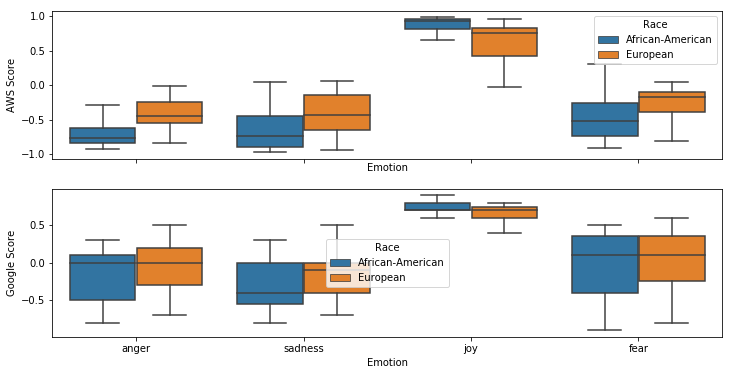

In [70]:
race_combined_data,  racial_bias_uniform_df = create_bias_df('Race')

In [71]:
race_combined_data[:5]

,AWS Score,Race,Emotion,Google Score
0,-0.870244,African-American,anger,0.0
1,-0.770119,African-American,anger,0.1
2,-0.901797,African-American,anger,-0.5
3,-0.866943,African-American,anger,0.0
4,-0.916180,African-American,anger,-0.6


Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: anger, p-value (Wilcoxon) : 0.00000
Google emotion: anger, p-value (Wilcoxon) : 0.59611
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: sadness, p-value (Wilcoxon) : 0.00002
Google emotion: sadness, p-value (Wilcoxon) : 0.10247
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: joy, p-value (Wilcoxon) : 0.00000
Google emotion: joy, p-value (Wilcoxon) : 0.31731
Length of affected_class: 35
Length of impacting_class: 35
AWS emotion: fear, p-value (Wilcoxon) : 0.00001
Google emotion: fear, p-value (Wilcoxon) : 0.01695


/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/anaconda2/envs/ml/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


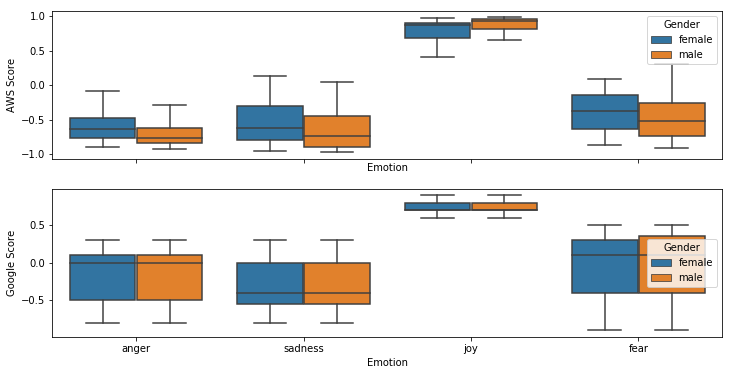

In [72]:
gender_combined_data, gender_bias_uniform_df = create_bias_df('Gender')

In [73]:
gender_combined_data[:5]

,AWS Score,Gender,Emotion,Google Score
0,-0.770503,female,anger,0.0
1,-0.635181,female,anger,0.1
2,-0.812801,female,anger,-0.5
3,-0.761539,female,anger,0.0
4,-0.839454,female,anger,-0.6


In [24]:
race_combined_data[['Race', 'Score', 'Emotion']].to_csv('./race_data_with_scores.csv', index=None)

In [25]:
gender_combined_data[['Gender', 'Score', 'Emotion']].to_csv('./gender_data_with_scores.csv', index=None)